In [2]:
import os
import numpy as np
from Data_Generator import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [3]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

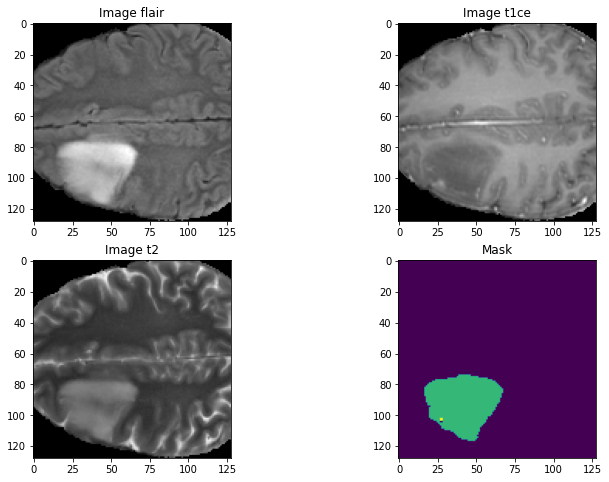

In [4]:
img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [5]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

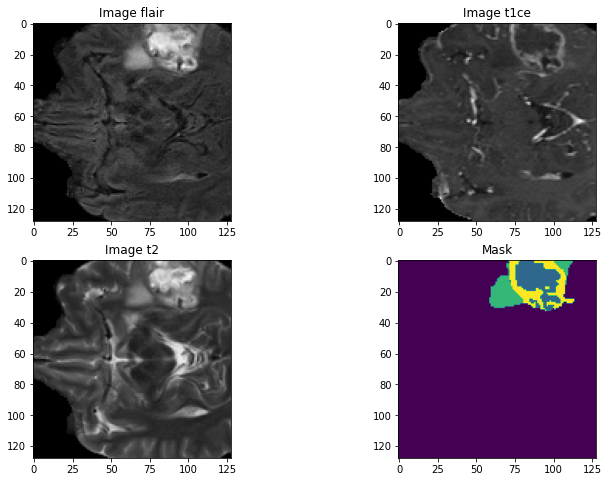

In [7]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

img, msk = val_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [8]:
# import pandas as pd
# columns = ['0','1', '2', '3']
# df = pd.DataFrame(columns=columns)
# train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
# for img in range(len(train_mask_list)):
#     print(img)
#     temp_image=np.load(train_mask_list[img])
#     temp_image = np.argmax(temp_image, axis=3)
#     val, counts = np.unique(temp_image, return_counts=True)
#     zipped = zip(columns, counts)
#     conts_dict = dict(zipped)
    
#     df = df.append(conts_dict, ignore_index=True)

# label_0 = df['0'].sum()
# label_1 = df['1'].sum()
# label_2 = df['1'].sum()
# label_3 = df['3'].sum()
# total_labels = label_0 + label_1 + label_2 + label_3
# n_classes = 4
# #Class weights claculation: n_samples / (n_classes * n_samples_for_class)
# wt0 = round((total_labels/(n_classes*label_0)), 2) 
# wt1 = round((total_labels/(n_classes*label_1)), 2)
# wt2 = round((total_labels/(n_classes*label_2)), 2)
# wt3 = round((total_labels/(n_classes*label_3)), 2)

wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

In [9]:
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

Segmentation Models: using `tf.keras` framework.


In [10]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [14]:
encoder_weights = 'imagenet'
BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 128
n_classes = 4
channels=3

# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [15]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [16]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 12  9           ['data[0][0]']                   
                                8, 3)                                                             
                                                                                                  
 zero_padding3d_18 (ZeroPadding  (None, 134, 134, 13  0          ['bn_data[0][0]']                
 3D)                            4, 3)                                                       

                                                                                                  
 stage1_unit2_bn3 (BatchNormali  (None, 32, 32, 32,   256        ['stage1_unit2_conv2[0][0]']     
 zation)                        64)                                                               
                                                                                                  
 stage1_unit2_relu3 (Activation  (None, 32, 32, 32,   0          ['stage1_unit2_bn3[0][0]']       
 )                              64)                                                               
                                                                                                  
 stage1_unit2_conv3 (Conv3D)    (None, 32, 32, 32,   16384       ['stage1_unit2_relu3[0][0]']     
                                256)                                                              
                                                                                                  
 add_17 (A

 zation)                        512)                                                              
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, 16, 16, 16,   0          ['stage2_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit2_conv1 (Conv3D)    (None, 16, 16, 16,   65536       ['stage2_unit2_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit2_bn2 (BatchNormali  (None, 16, 16, 16,   512        ['stage2_unit2_conv1[0][0]']     
 zation)                        128)                                                              
          

 stage2_unit4_conv2 (Conv3D)    (None, 16, 16, 16,   442368      ['zero_padding3d_26[0][0]']      
                                128)                                                              
                                                                                                  
 stage2_unit4_bn3 (BatchNormali  (None, 16, 16, 16,   512        ['stage2_unit4_conv2[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_unit4_relu3 (Activation  (None, 16, 16, 16,   0          ['stage2_unit4_bn3[0][0]']       
 )                              128)                                                              
                                                                                                  
 stage2_unit4_conv3 (Conv3D)    (None, 16, 16, 16,   65536       ['stage2_unit4_relu3[0][0]']     
          

                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 8, 8, 8, 102  4096       ['add_24[0][0]']                 
 zation)                        4)                                                                
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 8, 8, 8, 102  0          ['stage3_unit3_bn1[0][0]']       
 )                              4)                                                                
                                                                                                  
 stage3_unit3_conv1 (Conv3D)    (None, 8, 8, 8, 256  262144      ['stage3_unit3_relu1[0][0]']     
                                )                                                                 
                                                                                                  
 stage3_un

 3D)                            256)                                                              
                                                                                                  
 stage3_unit5_conv2 (Conv3D)    (None, 8, 8, 8, 256  1769472     ['zero_padding3d_31[0][0]']      
                                )                                                                 
                                                                                                  
 stage3_unit5_bn3 (BatchNormali  (None, 8, 8, 8, 256  1024       ['stage3_unit5_conv2[0][0]']     
 zation)                        )                                                                 
                                                                                                  
 stage3_unit5_relu3 (Activation  (None, 8, 8, 8, 256  0          ['stage3_unit5_bn3[0][0]']       
 )                              )                                                                 
          

 add_29 (Add)                   (None, 4, 4, 4, 204  0           ['stage4_unit1_conv3[0][0]',     
                                8)                                'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, 4, 4, 4, 204  8192       ['add_29[0][0]']                 
 zation)                        8)                                                                
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, 4, 4, 4, 204  0          ['stage4_unit2_bn1[0][0]']       
 )                              8)                                                                
                                                                                                  
 stage4_unit2_conv1 (Conv3D)    (None, 4, 4, 4, 512  1048576     ['stage4_unit2_relu1[0][0]']     
          

                                )                                                                 
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, 8, 8, 8, 256  1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage0a_relu (Activati  (None, 8, 8, 8, 256  0          ['decoder_stage0a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage0b_conv (Conv3D)  (None, 8, 8, 8, 256  1769472     ['decoder_stage0a_relu[0][0]']   
                                )                                                                 
          

 decoder_stage3b_conv (Conv3D)  (None, 64, 64, 64,   27648       ['decoder_stage3a_relu[0][0]']   
                                32)                                                               
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, 64, 64, 64,   128        ['decoder_stage3b_conv[0][0]']   
 lization)                      32)                                                               
                                                                                                  
 decoder_stage3b_relu (Activati  (None, 64, 64, 64,   0          ['decoder_stage3b_bn[0][0]']     
 on)                            32)                                                               
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, 128, 128, 12  0          ['decoder_stage3b_relu[0][0]']   
 ampling3D

In [46]:
from simple_3D_Unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_76 (Conv3D)             (None, 128, 128, 12  1312        ['input_5[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_36 (Dropout)           (None, 128, 128, 12  0           ['conv3d_76[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_88 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_17[0][0]']         
                                64)                                                               
                                                                                                  
 dropout_42 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_88[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_89 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_42[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

                                64)                                                               
                                                                                                  
 max_pooling3d_18 (MaxPooling3D  (None, 16, 16, 16,   0          ['conv3d_81[0][0]']              
 )                              64)                                                               
                                                                                                  
 conv3d_82 (Conv3D)             (None, 16, 16, 16,   221312      ['max_pooling3d_18[0][0]']       
                                128)                                                              
                                                                                                  
 dropout_39 (Dropout)           (None, 16, 16, 16,   0           ['conv3d_82[0][0]']              
                                128)                                                              
          

 conv3d_93 (Conv3D)             (None, 128, 128, 12  6928        ['dropout_44[0][0]']             
                                8, 16)                                                            
                                                                                                  
 conv3d_94 (Conv3D)             (None, 128, 128, 12  68          ['conv3d_93[0][0]']              
                                8, 4)                                                             
                                                                                                  
Total params: 5,645,828
Trainable params: 5,645,828
Non-trainable params: 0
__________________________________________________________________________________________________
None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [17]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/10


2022-07-29 08:40:58.373991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/model_3/stage2_unit4_conv2/Conv3D/Shape' exist for missing node 'model_3/zero_padding3d_26/Pad'.
2022-07-29 08:40:58.734741: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/model_3/stage2_unit4_conv2/Conv3D/Shape' exist for missing node 'model_3/zero_padding3d_26/Pad'.


137/137 [==============================] - 1263s 9s/step - loss: 0.9511 - accuracy: 0.8752 - iou_score: 0.2533 - val_loss: 0.9538 - val_accuracy: 0.9470 - val_iou_score: 0.2475
Epoch 2/10
137/137 [==============================] - 1279s 9s/step - loss: 0.8852 - accuracy: 0.9692 - iou_score: 0.4694 - val_loss: 0.9540 - val_accuracy: 0.9471 - val_iou_score: 0.2515
Epoch 3/10
137/137 [==============================] - 1277s 9s/step - loss: 0.8479 - accuracy: 0.9742 - iou_score: 0.5543 - val_loss: 0.9758 - val_accuracy: 0.9281 - val_iou_score: 0.2324
Epoch 4/10
137/137 [==============================] - 1284s 9s/step - loss: 0.8333 - accuracy: 0.9773 - iou_score: 0.5938 - val_loss: 0.9651 - val_accuracy: 0.9471 - val_iou_score: 0.2515
Epoch 5/10
137/137 [==============================] - 1291s 9s/step - loss: 0.8258 - accuracy: 0.9791 - iou_score: 0.6196 - val_loss: 0.9854 - val_accuracy: 0.9094 - val_iou_score: 0.2368
Epoch 6/10
137/137 [==============================] - 1296s 9s/step - l

In [18]:
model.save('brats_3d.hdf5')

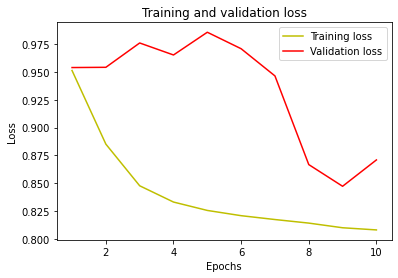

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

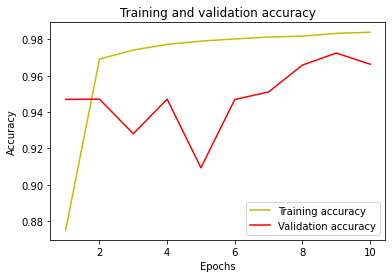

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
from keras.models import load_model

#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and 
#continue training we need to provide these as custom_objects.
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
my_model = load_model('brats_3d.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
#Now all set to continue the training process. 
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

In [22]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 24s 24s/step
Mean IoU = 0.6529408


In [23]:
img_num = 36

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'BraTS2020_TrainingData/input_data_128/val/images/image_36.npy'